This notebook
 * checks the mask,
 * displays the simulation maps, both ILC and noise,
 * derives the transfer-function,
 * calculates the central noise level
 * calculates tniti

In [1]:
import numpy as np
import healpy as hp
import os, sys
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import component_separation.MSC.MSC.pospace as ps

from lerepi.data.dc08d import sims_interface
sims_lerepi  = sims_interface.ILC_May2022('00')


simids = np.array([0])
nside = 2048
lmax = 2047
lmax_plot = lmax

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

ModuleNotFoundError: No module named 'numpy'

# Check mask

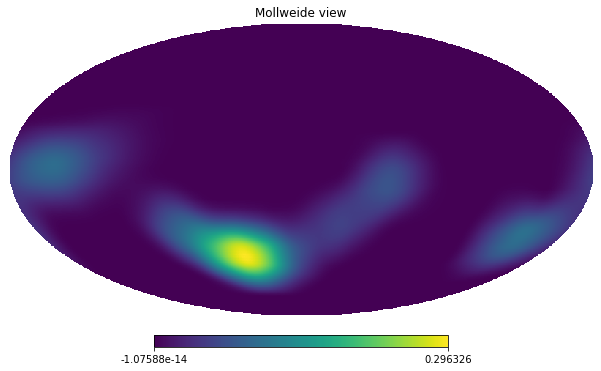

In [4]:
mask = sims_lerepi.get_mask()
hp.mollview(mask)

# Display maps / noise

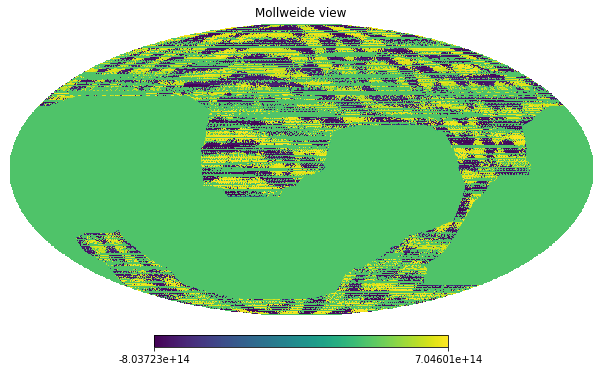

In [8]:
q, u = sims_lerepi.get_sim_pmap(0)
hp.mollview(q, norm='hist')

In [6]:
Cl = ps.map2cl_spin([q,u], spin=2, mask=mask, lmax=lmax-1, lmax_mask=lmax)

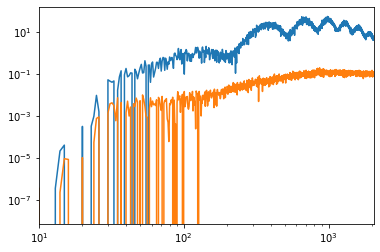

In [21]:
plt.plot(Cl[0]*scale_ps)
plt.plot(Cl[1]*scale_ps)
plt.xlim(10,2048)
plt.xscale('log')
plt.yscale('log')

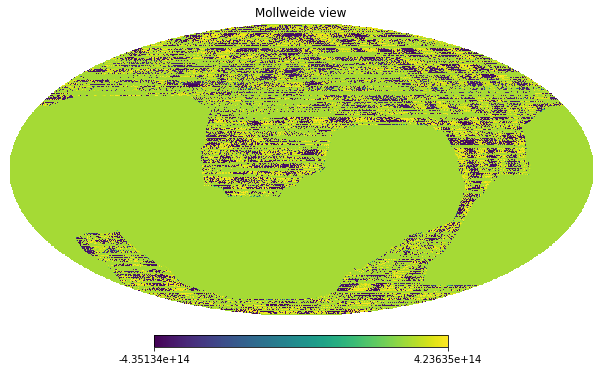

In [24]:
Nq, Nu = sims_lerepi.get_noise_sim_pmap(0)
hp.mollview(Nq, norm='hist')

In [27]:
ClN = ps.map2cl_spin([Nq,Nu], spin=2, mask=mask, lmax=lmax, lmax_mask=lmax)

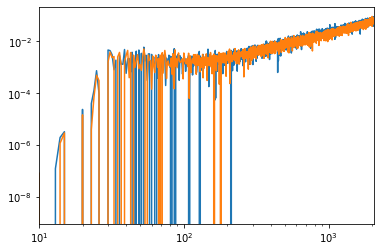

In [28]:
plt.plot(ClN[0]*scale_ps)
plt.plot(ClN[1]*scale_ps)
plt.xlim(10,2048)
plt.xscale('log')
plt.yscale('log')

# Derive transferfunction

In [102]:
beam = 2.3
lmax_transf = 2048
tf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf) * hp.pixwin(2048, lmax=lmax_transf)

In [30]:
def TEBlm_f(simidx):
    '''
    Returns fiducial ffp10 powerspectrum
    '''
    ffp10scalmTEB = 1e6 * hp.read_alm('/project/projectdirs/cmb/data/generic/cmb/ffp10/mc/scalar/ffp10_lensed_scl_cmb_000_alm_mc_%04d.fits'%simidx, hdu=(1,2,3))
    return ffp10scalmTEB

tebmap_f = np.array([hp.alm2map(TEBlm_f(simidx), nside=2048, pol=False) for simidx in simids]) # almTEB -> mapTEB

In [63]:
ClEE_f = ps.map2cl(tebmap_f[0,1], mask=mask, lmax=lmax, lmax_mask=lmax)
ClBB_f = ps.map2cl(tebmap_f[0,2], mask=mask, lmax=lmax, lmax_mask=lmax)

In [ ]:
Cl_fxD = ps.map2cl(tebmap_f[0,1]-, mask=mask, lmax=lmax, lmax_mask=lmax)

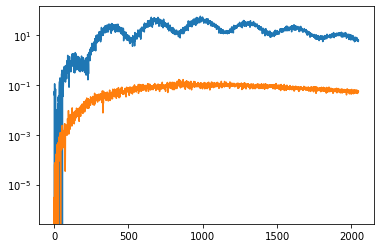

In [64]:
plt.plot(ClEE_f*scale_ps)
plt.plot(ClBB_f*scale_ps)
plt.yscale('log')

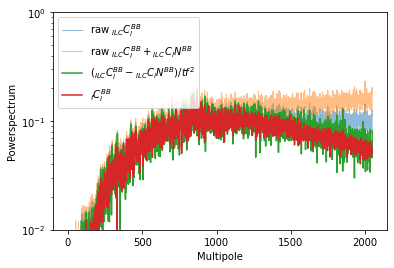

In [105]:
plt.plot(Cl[1]*scale_ps, label=r'raw $_{ILC}C_l^{BB}$', lw=1, alpha=0.5)
plt.plot((Cl[1]+ClN[1])*scale_ps, label=r'raw $_{ILC}C_l^{BB}+_{ILC}C_lN^{BB}$', lw=1, alpha=0.5)
# plt.plot(1/tf**2, label=r"$Tf^{2'3''}_p$")

plt.plot((Cl[1]-ClN[1])*scale_ps/tf[:2048]**2, label=r'$(_{ILC}C_l^{BB} -_{ILC}C_lN^{BB}) /tf^2$')
plt.plot(ClBB_f*scale_ps, label=r'$_fC_l^{BB}$')

plt.yscale('log')
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

plt.ylim((1e-2,1e0))
plt.legend()

# Check masks

In [60]:
mask_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
mask_chiledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')

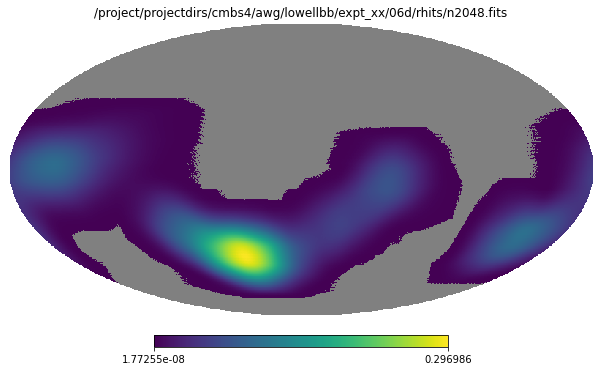

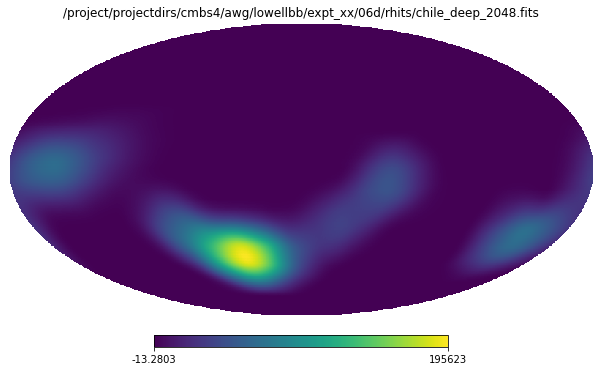

In [61]:
hp.mollview(mask_n2048, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/n2048.fits')
hp.mollview(mask_chiledeep, title='/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06d/rhits/chile_deep_2048.fits')

In [118]:
mask_poledeep = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/pole_deep_2048.fits')
mask_pole_n2048 = hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/06/rhits/n2048.fits')

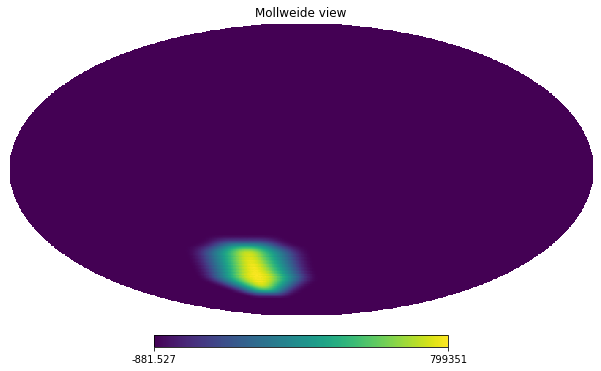

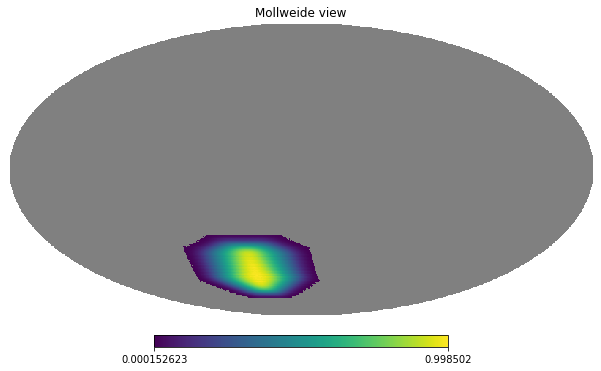

In [119]:
hp.mollview(mask_pole_n2048)
hp.mollview(mask_poledeep)

# Calculate central noise levels

In [20]:
NQU = sims_lerepi.get_noise_sim_pmap(0)

In [21]:
NQUlm_cm = hp.map2alm(NQU[0]*mask)
NQUlm_cm_bp = bandpass_alms(NQUlm_cm,2,200)
NQU_bp = hp.alm2map(NQUlm_cm_bp, nside=2048)

TypeError: alm2map() missing 1 required positional argument: 'nside'

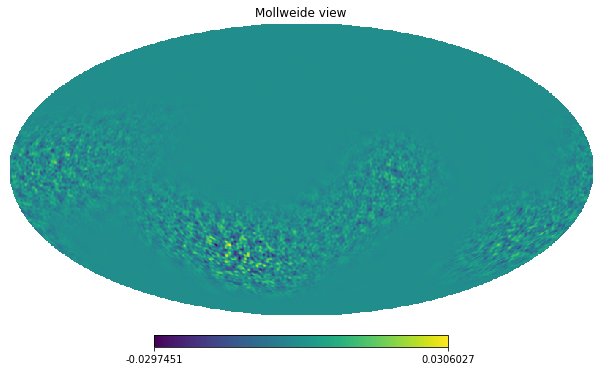

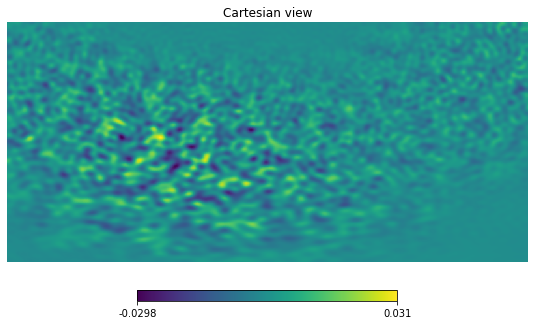

In [53]:
hp.mollview(NQU_bp)
hp.cartview(NQU_bp, lonra=[-40,90], latra=[-70,-10])

## Build noise template

(1e-09, 1e-05)

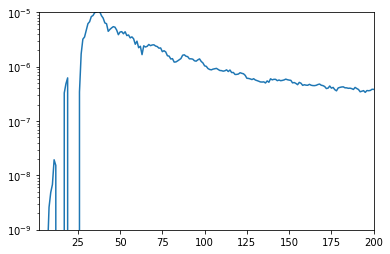

In [73]:
from scipy.signal import savgol_filter as sf
plt.plot(sf(ClN_QU_cs_pospace, 21, 3))
plt.yscale('log')
plt.xlim((2,200))
plt.ylim((1e-9,1e-5))

In [141]:
from scipy.signal import savgol_filter as sf
ClN_QU_cs_pospace = ps.map2cl(NQU[0], np.where(mask<0.01,0,mask), 2048, 4096)
clN_templ = sf(ClN_QU_cs_pospace, 21, 3)
clN_templ.shape

(2049,)

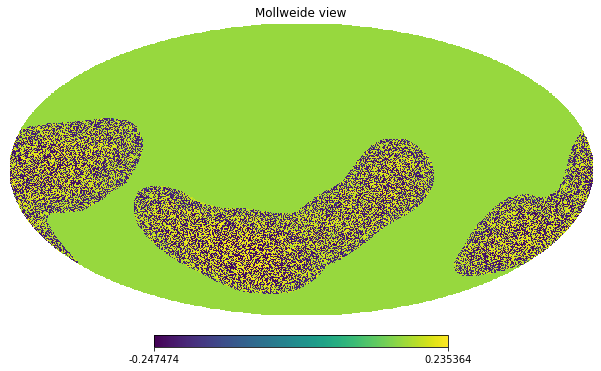

In [140]:
hp.mollview(NQU[0]*np.where(mask<0.01,0,mask), norm='hist')

(1e-09, 1e-05)

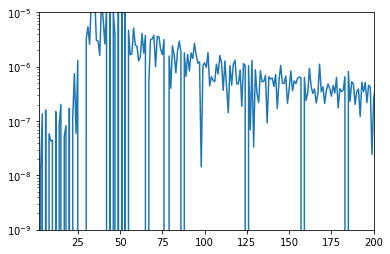

In [142]:
plt.plot(ClN_QU_cs_pospace)
plt.yscale('log')
plt.xlim((2,200))
plt.ylim((1e-9,1e-5))

## Choose mask for central value

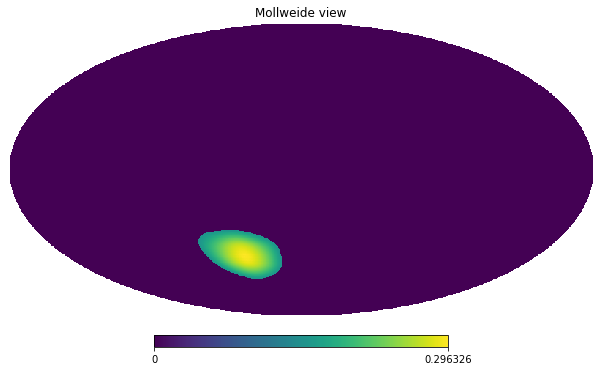

In [144]:
edges_center = (cmbs4_edges[1:]+cmbs4_edges[:-1])/2
hp.mollview(np.where(mask>0.15,mask,0))
np.sum(np.where(mask>0.15,1,0))/len(mask)

## Calculate

In [220]:
from component_separation.MSC.MSC import pospace as ps

cmbs4_edges = np.array([30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000])
edges_center = (cmbs4_edges[1:]+cmbs4_edges[:-1])/2
lmax_cl = 1024
lmax_lib = 2*lmax_cl-1
ClN_binned = ps.map2cl_binned(np.where(mask>0.15,mask,0), clN_templ, cmbs4_edges, lmax_lib)

Calculating coupling matrix...
zero ww at 43.2 deg
 [00:00:00]  ---------> 91%


In [213]:
ClN_binned_cs = ClN_binned.map2cl(NQU[0])

ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

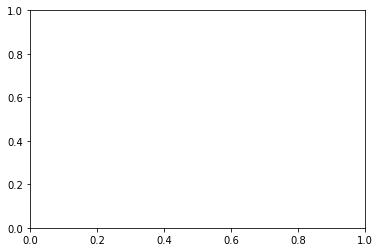

In [214]:
plt.plot(edges_center, ClN_binned_cs)
plt.xlim(2,200)
plt.ylim(0,2)

# Now, repeat this for s08b. Should lead to central noise level of 0.42 mu K arcmin

In [215]:
from lerepi.data.dc08b import sims_interface
sims_may  = sims_interface.caterinaILC_May12('00')
N_08b = sims_may.get_noise_sim_pmap(0)
mask_08b = hp.read_map(sims_may.p2mask)

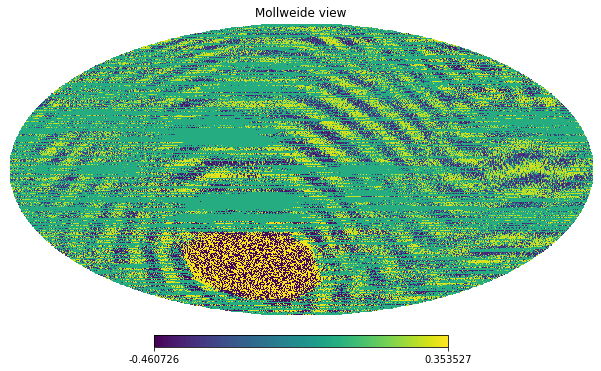

In [216]:
hp.mollview(N_08b[0]*mask_08b, norm='hist')

In [217]:
bin_lib = ps.map2cl_binned(mask_08b, np.where(clN_templ>0,clN_templ,0), cmbs4_edges, lmax_lib)
CN_08b_binned = bin_lib.map2cl(N_08b[0])
CN_08b = ps.map2cl(N_08b[0], mask_08b, 1024, 2048)

Calculating coupling matrix...
zero ww at 53.6 deg
 [00:00:00]  ---------> 91%


array([       nan, 2.35598849,        nan, 1.21264178, 0.71519156,
       0.68030817, 0.64379881, 0.65593785, 0.54790944, 0.45953883,
       0.48698918])

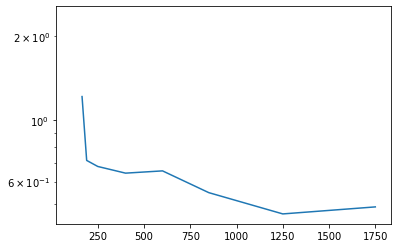

Text(0, 0.5, '$C_l \\ell(\\ell+1)$/2$\\pi$')

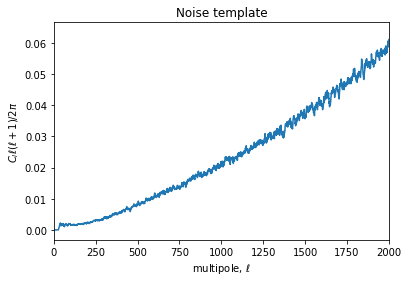

In [232]:
plt.plot(np.where(clN_templ>0,clN_templ,0)[:2048]*scale_ps)
plt.xlim(0,2000)
# plt.ylim(0,0.01)
plt.title('Noise template')
plt.xlabel('multipole, $\ell$')
plt.ylabel('$C_l \ell(\ell+1)$/2$\pi$')

array([       nan, 2.35598849,        nan, 1.21264178, 0.71519156,
       0.68030817, 0.64379881, 0.65593785, 0.54790944, 0.45953883,
       0.48698918])

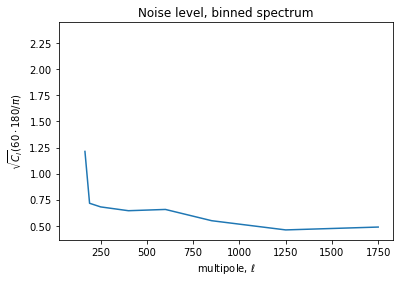

In [228]:
plt.plot(edges_center[1:], np.sqrt(CN_08b_binned[1:]*clN_templ[[int(e) for e in edges_center]][1:]) * (60 * 180 / np.pi))
plt.title('Noise level, binned spectrum')
plt.xlabel('multipole, $\ell$')
plt.ylabel('$\sqrt{C_l} (60 \cdot 180 / \pi)$')
np.sqrt(CN_08b_binned[1:]*clN_templ[[int(e) for e in edges_center]][1:]) * (60 * 180 / np.pi)